# Positional Validation


In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl

ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

## Read the Data


In [2]:
veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    .sort(
        "gps_time",
    )
    .with_row_count(name="seq")
)

### Map to Lanes


In [3]:
import geopandas as gpd
from src.geometry import RoadNetwork


network = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
)

lane_df = network.df

## Snap the Vehicle Trajectories to Lanes


In [4]:
import utm

x, y, _, _ = utm.from_latlon(
    latitude=veh_df["lat"].to_numpy(),
    longitude=veh_df["lon"].to_numpy(),
)

veh_df = (
    veh_df.with_columns(
        x=x,
        y=y,
    )
    .with_columns(
        (pl.col("x").diff() ** 2 + pl.col("y").diff() ** 2).sqrt().alias("dist"),
    )
    .with_columns(
        (
            pl.col("dist") / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("speed"),
    )
)

veh_df.head()

shape: (5, 9)
┌─────┬───────────────┬───────────┬────────────┬───┬──────────────┬──────────┬──────────┬──────────┐
│ seq ┆ gps_time      ┆ lat       ┆ lon        ┆ … ┆ x            ┆ y        ┆ dist     ┆ speed    │
│ --- ┆ ---           ┆ ---       ┆ ---        ┆   ┆ ---          ┆ ---      ┆ ---      ┆ ---      │
│ u32 ┆ datetime[μs,  ┆ f64       ┆ f64        ┆   ┆ f64          ┆ f64      ┆ f64      ┆ f64      │
│     ┆ UTC]          ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
╞═════╪═══════════════╪═══════════╪════════════╪═══╪══════════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97831 ┆ 3.6775e6 ┆ null     ┆ null     │
│     ┆ 16:43:11.400  ┆           ┆            ┆   ┆ 5            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 1   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97869 ┆ 3.6775e6 ┆ 0.000962 ┆ 0.009621 │
│     ┆ 16:43:11.500  ┆           ┆            ┆   ┆ 2            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 2   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97924 ┆ 3.6775e6 ┆ 0.000787 ┆ 0.007873 │
│     ┆ 16:43:11.600  ┆           ┆            ┆   ┆ 8            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 3   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97850 ┆ 3.6775e6 ┆ 0.000816 ┆ 0.008162 │
│     ┆ 16:43:11.700  ┆           ┆            ┆   ┆ 1            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 4   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97897 ┆ 3.6775e6 ┆ 0.000724 ┆ 0.007241 │
│     ┆ 16:43:11.800  ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
└─────┴───────────────┴───────────┴────────────┴───┴──────────────┴──────────┴──────────┴──────────┘

### Build the KDTree


In [5]:
veh_df = network.map_to_lane(
    veh_df,
    dist_upper_bound=3,
    utm_x_col="x",
    utm_y_col="y",
)

In [6]:
veh_df = (
    veh_df.with_columns(
        pl.col("name").fill_null(""),
    )
    .with_columns(
        (
            (pl.col("name").shift(1) != pl.col("name"))
            & (pl.col("name").shift(1) != "")
        ).alias("sequence"),
    )
    .with_columns(
        (pl.col("sequence").cum_sum() * (pl.col("name") != "")).alias("sequence_id"),
    )
    .filter(pl.col("sequence_id") != 0)
)

In [7]:
veh_df.head()

shape: (5, 18)
┌──────┬────────────────────┬───────────┬────────────┬───┬─────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time           ┆ lat       ┆ lon        ┆ … ┆ angle   ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---                ┆ ---       ┆ ---        ┆   ┆ ---     ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs, UTC]  ┆ f64       ┆ f64        ┆   ┆ f64     ┆ str  ┆ bool     ┆ u32         │
╞══════╪════════════════════╪═══════════╪════════════╪═══╪═════════╪══════╪══════════╪═════════════╡
│ 1325 ┆ 2023-10-31         ┆ 33.235712 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ true     ┆ 1           │
│      ┆ 16:45:35.200 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1326 ┆ 2023-10-31         ┆ 33.235719 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.300 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1327 ┆ 2023-10-31         ┆ 33.235726 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.400 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1328 ┆ 2023-10-31         ┆ 33.235734 ┆ -87.610402 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.500 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1329 ┆ 2023-10-31         ┆ 33.235741 ┆ -87.610402 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.600 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
└──────┴────────────────────┴───────────┴────────────┴───┴─────────┴──────┴──────────┴─────────────┘

In [8]:
ebl1_df = veh_df.filter(pl.col("sequence_id") == 12).with_columns(
    (
        pl.col("s").diff() / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
    ).alias("speed")
)

In [9]:
ebl1_df.head()

shape: (5, 18)
┌──────┬──────────────────┬───────────┬────────────┬───┬───────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time         ┆ lat       ┆ lon        ┆ … ┆ angle     ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---              ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs,     ┆ f64       ┆ f64        ┆   ┆ f64       ┆ str  ┆ bool     ┆ u32         │
│      ┆ UTC]             ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
╞══════╪══════════════════╪═══════════╪════════════╪═══╪═══════════╪══════╪══════════╪═════════════╡
│ 8562 ┆ 2023-10-31       ┆ 33.234887 ┆ -87.614469 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.600 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8563 ┆ 2023-10-31       ┆ 33.234893 ┆ -87.614466 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.700 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8564 ┆ 2023-10-31       ┆ 33.234898 ┆ -87.614463 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.800 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8565 ┆ 2023-10-31       ┆ 33.234903 ┆ -87.614461 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.900 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8566 ┆ 2023-10-31       ┆ 33.234908 ┆ -87.614459 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:47 UTC     ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
└──────┴──────────────────┴───────────┴────────────┴───┴───────────┴──────┴──────────┴─────────────┘

## Read in the Trajectories


In [10]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


# make a consolidated network with only EBL1 and WBL1

mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
)

radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


radar_df = (
    pl.scan_parquet(
        ROOT.joinpath("data", "raw", "*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(seconds=30),
            pl.col("gps_time").max() + timedelta(seconds=30),
        )
    )
    # .filter(pl.col("ip").str.split(".").list.last().is_in(["146", "147", "142"]))
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    # .filter(pl.col("ip").str.contains("146")
    # .collect()
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=10,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .rename({"name": "lane"})
)

function: create_object_id took: 0.016485214233398438 seconds
function: filter_short_trajectories took: 0.010190725326538086 seconds
function: clip_trajectory_end took: 0.00023865699768066406 seconds
function: resample took: 0.0009930133819580078 seconds
function: fix_duplicate_positions took: 9.989738464355469e-05 seconds
function: set_timezone took: 0.0004379749298095703 seconds
function: add_cst_timezone took: 2.09808349609375e-05 seconds
function: add_heading took: 3.314018249511719e-05 seconds
function: rotate_radars took: 0.00017714500427246094 seconds
function: update_origin took: 0.0004189014434814453 seconds


In [11]:
# radar_df.filter(
#     pl.col('object_id') == 3631321283062933221
# )

In [12]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)

radar_df = (
    radar_df.rename(
        {
            "angle": "heading_lane",
        }
    )
    .pipe(filter_short_trajectories, minimum_distance_m=10, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension)
    .pipe(add_timedelta)
    .pipe(build_kalman_id)
    .collect()
)

function: filter_short_trajectories took: 0.03796982765197754 seconds
function: prepare_frenet_measurement took: 0.00026488304138183594 seconds
function: build_extension took: 0.5878031253814697 seconds
function: add_timedelta took: 6.341934204101562e-05 seconds
function: build_kalman_id took: 0.00011897087097167969 seconds


In [13]:
radar_df.filter(
    (pl.col("epoch_time") - pl.col("epoch_time").min()).dt.total_minutes() < 2
).pipe(
    radar_obj.radar_to_latlon,
    utm_x_col="x_lane",
    utm_y_col="y_lane",
    lat_col="lat_lane",
    lon_col="lon_lane",
).select(
    ["object_id", "epoch_time", "lat", "lon", "lat_lane", "lon_lane", "ip"]
).write_csv(ROOT / "data" / "radar_lane.csv")

function: radar_to_latlon took: 0.011616945266723633 seconds


In [14]:
radar_df[["s", "s_velocity", "d", "d_velocity"]].describe()

shape: (9, 5)
┌────────────┬─────────────┬────────────┬────────────┬────────────┐
│ describe   ┆ s           ┆ s_velocity ┆ d          ┆ d_velocity │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64         ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪═════════════╪════════════╪════════════╪════════════╡
│ count      ┆ 1.126956e6  ┆ 1.126956e6 ┆ 1.126956e6 ┆ 1.126956e6 │
│ null_count ┆ 0.0         ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 864.345048  ┆ 14.006391  ┆ 0.204483   ┆ -0.139993  │
│ std        ┆ 335.323632  ┆ 7.576199   ┆ 3.83997    ┆ 0.654555   │
│ min        ┆ 20.700023   ┆ 0.0        ┆ -9.99861   ┆ -7.586312  │
│ 25%        ┆ 573.900636  ┆ 8.407294   ┆ -2.137668  ┆ -0.344284  │
│ 50%        ┆ 843.200935  ┆ 15.52581   ┆ 0.134916   ┆ -0.045114  │
│ 75%        ┆ 1165.701293 ┆ 19.944644  ┆ 3.089963   ┆ 0.137585   │
│ max        ┆ 1693.401878 ┆ 34.049948  ┆ 9.999982   ┆ 5.606703   │
└────────────┴─────────────┴────────────┴────────────┴────────────┘

In [15]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = radar_df.pipe(build_kalman_df).collect()

function: build_kalman_df took: 0.003710031509399414 seconds


### Loop through all the Trajectories and find the Trouble Ones


In [16]:
# from src.filters.vectorized_kalman import IMMFilter, CALCFilter, CVLKFilter
# import numpy as np


# for vehicle_id in filter_df["vehicle_ind"].unique():
#     veh_df = filter_df.filter(pl.col("vehicle_ind") == vehicle_id).with_columns(
#         pl.lit(0).alias("vehicle_ind")
#     )

#     IMMFilter(
#         df=veh_df.rename({"measurement": "z"}),
#         filters=("CALC", "CALK", "CVLK"),
#         M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
#         mu=np.array([0.05, 0.3, 0.65]),
#         gpu=False,
#     ).apply_filter()

In [17]:
# radar_df.filter(pl.col("kalman_id") == veh_df["kalman_id"][0])

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from src.filters.vectorized_kalman import IMMFilter, CALCFilter, CVLKFilter
import numpy as np


# from src.filters.kalman2 import kf_filter_lanechange

# veh = joined_df['object_id'].sample(1).to_numpy()[0]
veh_id = filter_df.filter(pl.col("vehicle_ind") == 77)["kalman_id"][0]
# veh_df = joined_df.filter(pl.col("vehicle_ind") == veh).sort("epoch_time")
plot_veh_df = filter_df.filter(pl.col("kalman_id") == veh_id).sort("epoch_time")

fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    subplot_titles=(
        f"Vehicle {veh_id} S",
        f"Vehicle {veh_id} D",
    ),
    # add a secondary y axis to the velocity plots
    specs=[
        [{"secondary_y": True}],
        [{"secondary_y": True}],
        [{"secondary_y": False}],
    ],
)


colors = {
    "": "blue",
    "_filt": "red",
}


for df, ext in [
    (plot_veh_df, ""),
]:
    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(0),
            mode="markers+lines",
            name=f"S{ext}",
            marker_color=colors[ext],
            line_dash="dash",
        ),
        row=1,
        col=1,
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=veh_df["epoch_time"],
    #         y=res[0][:, 0, 0],
    #         mode="markers+lines",
    #         name=f"S{ext}_filt",
    #         marker_color=colors[ext],
    #     ),
    #     row=1,
    #     col=1,
    # )

    # fig.add_trace(
    #     go.Scatter(
    #         x=veh_df["epoch_time"],
    #         y=res[0][:, 0, 1],
    #         mode="markers+lines",
    #         name=f"S Velocity{ext}_filt",
    #         marker_color=colors[ext],
    #     ),
    #     row=1,
    #     col=1,
    #     secondary_y=True,
    # )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(1),
            mode="markers+lines",
            name=f"S Velocity{ext}",
            marker_color=colors[ext],
        ),
        row=1,
        col=1,
        secondary_y=True,
    )

    # add the D dimension
    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(2),
            mode="markers+lines",
            name=f"D{ext}",
            marker_color=colors[ext],
        ),
        row=2,
        col=1,
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=veh_df["epoch_time"],
    #         y=res[0][:, 0, 3],
    #         mode="markers+lines",
    #         name=f"D{ext}_filt",
    #         marker_color=colors[ext],
    #     ),
    #     row=2,
    #     col=1,
    # )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(3),
            mode="markers+lines",
            name=f"D Velocity{ext}",
            marker_color=colors[ext],
        ),
        row=2,
        col=1,
        secondary_y=True,
    )


fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time"],
        y=plot_veh_df["missing_data"],
        mode="markers+lines",
        name="Missing Data",
        marker_color="green",
    ),
    row=3,
    col=1,
)


# for p in ["mu_CALC", "mu_CALK", "mu_CVLK"]:
#     # plot the probabilities
#     fig.add_trace(
#         go.Scatter(
#             x=veh_df["epoch_time"],
#             y=veh_df[p],
#             mode="markers+lines",
#             name=p,
#             # marker_color="green",
#         ),
#         row=3,
#         col=1,
#     )


# bound the y axis
# fig.update_yaxes(range=[-10, 100], row=1, col=1)
# fig.update_yaxes(range=[-10, 10], row=2, col=1)

fig.update_layout(
    height=800,
    width=1200,
)

### IMM Filter the Radar Trajectories


In [19]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    mu=np.array([0.05, 0.3, 0.65]),
    # chunk_size=3_500,
    chunk_size=1000,
    gpu=False,
)

100%|██████████| 8/8 [00:34<00:00,  4.35s/it]


In [20]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df).collect()

function: join_results took: 0.005364894866943359 seconds


## Plotting the Lanes


<Axes: ylabel='Frequency'>

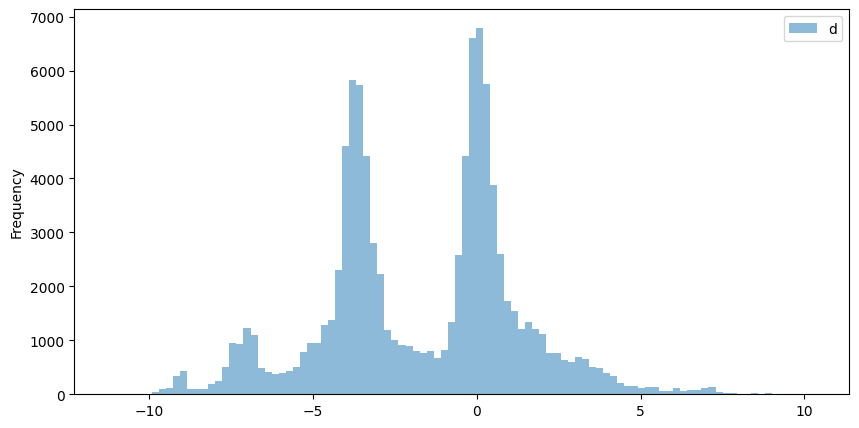

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("W"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

<Axes: ylabel='Frequency'>

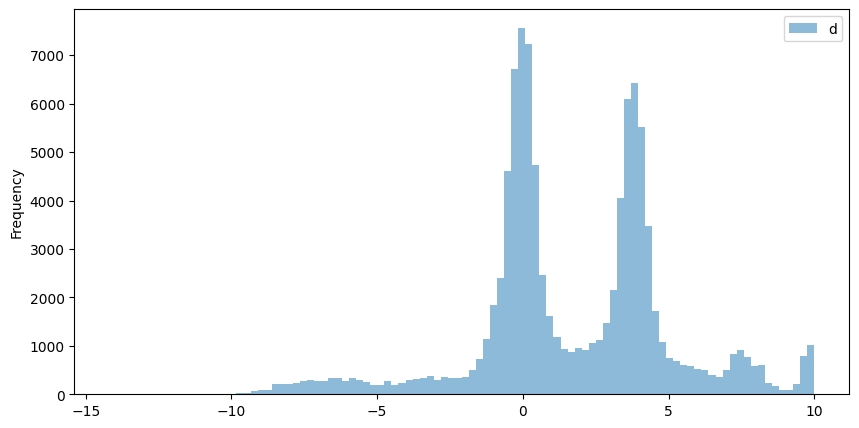

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("E"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

### Classify the Lanes


In [23]:
from src.pipelines.lane_classification import label_lane
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [24]:
joined_df = joined_df.pipe(label_lane, right_lane_center=0, lane_width=3.55)

function: label_lane took: 0.06104612350463867 seconds


In [25]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 5))

# laned_df.filter(pl.col("lane").str.contains("W") & pl.col('lane_index').is_not_null())[["d"]].sample(
#     100_000
# ).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5, )

# # set the range of the x-axis to be the same
# # ax.set_xlim(-6, 10)
# # radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

In [26]:
# eblm = build_lane_model(
#     lane_centers=[-3.5, 0, 3.5, 7],
#     train_data=joined_df.filter(
#         (pl.col("lane").str.contains("E"))
#         # & pl.col("d").is_between(-10, 10)
#         & ~pl.col('prediction')
#     )[["d"]],
#     priors=[0.05, 0.45, 0.45, 0.05],
#     variance=0.1,
# )

# fig, ax = plt.subplots(figsize=(10, 5))

# plot_model(
#     eblm,
#     ax=ax,
#     range=(-5, 8),
#     lane_names=["EBL1", "EBL2", "EBL3", "EBL4"],
# )

## Merge the Trajectories


In [27]:
from src.pipelines.association import build_leader_follower_df, add_front_back_s

lf_df = (
    joined_df.lazy()
    .pipe(add_front_back_s)
    .pipe(build_leader_follower_df)
    # only consider vehicles that are fairly close
    .filter(pl.col("s_gap") < 40)
    # don't keep matches that are both prediction
    .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    # assumption that radar tracks perfectly
    .filter(pl.col("ip") != pl.col("ip_leader"))
    .collect()
)

function: add_front_back_s took: 0.0001201629638671875 seconds
function: lazy_func took: 0.0008690357208251953 seconds


In [28]:
lf_df

shape: (240_237, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ object_id ┆ epoch_tim ┆ lane_hash ┆ leader    ┆ … ┆ P_leader  ┆ predictio ┆ ip_leader ┆ s_gap    │
│ ---       ┆ e         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ n_leader  ┆ ---       ┆ ---      │
│ u64       ┆ ---       ┆ u64       ┆ u64       ┆   ┆ array[f32 ┆ ---       ┆ str       ┆ f32      │
│           ┆ datetime[ ┆           ┆           ┆   ┆ , 36]     ┆ bool      ┆           ┆          │
│           ┆ ms, UTC]  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.636364 ┆ false     ┆ 10.160.7. ┆ 4.099854 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ , 0.0, …  ┆           ┆ 137       ┆          │
│ 7         ┆ 5.300 UTC ┆ 71        ┆ 1         ┆   ┆ 2.0]      ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.39178, ┆ false     ┆ 10.160.7. ┆ 4.04834  │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ 0.084957, ┆           ┆ 137       ┆          │
│ 7         ┆ 5.400 UTC ┆ 71        ┆ 1         ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 0.694023] ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.220535 ┆ false     ┆ 10.160.7. ┆ 4.09668  │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.500 UTC ┆ 71        ┆ 1         ┆   ┆ 0.130031, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 1.169665] ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [1.636364 ┆ false     ┆ 10.160.7. ┆ 8.566711 │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ , 2.5175e ┆           ┆ 146       ┆          │
│ 68        ┆ 5.600 UTC ┆ 17        ┆ 4         ┆   ┆ -11, …    ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 2.0]      ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 124190173 ┆ 2023-10-3 ┆ 799775751 ┆ 101935486 ┆ … ┆ [144.9773 ┆ true      ┆ 10.160.7. ┆ 17.88989 │
│ 859157548 ┆ 1 17:18:1 ┆ 592780717 ┆ 612383125 ┆   ┆ 56, 52.16 ┆           ┆ 142       ┆ 3        │
│ 23        ┆ 0.200 UTC ┆ 3         ┆ 21        ┆   ┆ 5436, …   ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 0.0]      ┆           ┆           ┆          │
│ 177595777 ┆ 2023-10-3 ┆ 131546905 ┆ 139559347 ┆ … ┆ [0.565099 ┆ false     ┆ 10.160.7. ┆ 14.41198 │
│ 843086266 ┆ 1 17:18:1 ┆ 103251931 ┆ 243121295 ┆   ┆ ,         ┆           ┆ 141       ┆ 7        │
│ 22        ┆ 0.200 UTC ┆ 71        ┆ 72        ┆   ┆ 0.282303, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 1.640077] ┆           ┆           ┆          │
│ 101935486 ┆ 2023-10-3 ┆ 799775751 ┆ 152558845 ┆ … ┆ [0.557608 ┆ false     ┆ 10.160.7. ┆ 19.45495 │
│ 612383125 ┆ 1 17:18:1 ┆ 592780717 ┆ 292125665 ┆   ┆ ,         ┆           ┆ 141       ┆ 6        │
│ 21        ┆ 0.200 UTC ┆ 3         ┆ 04        ┆   ┆ 0.281384, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 1.994401] ┆           ┆           ┆          │
│ 119378478 ┆ 2023-10-3 ┆ 799775751 ┆ 305968847 ┆ … ┆ [0.567083 ┆ false     ┆ 10.160.7. ┆ 6.319336 │
│ 21728597  ┆ 1 17:18:1 ┆ 592780717 ┆ 69

### Calculate the Association Log-Likelihood Distance


In [29]:
from src.pipelines.association import calc_assoc_liklihood_distance

lf_df = lf_df.pipe(
    calc_assoc_liklihood_distance,
    gpu=False,
)

function: lazy_func took: 0.7329740524291992 seconds


### Calculate the Match Indexes


In [30]:
from scipy.stats import chi
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
)

match_df = (
    lf_df.pipe(calculate_match_indexes, match_time_threshold=0.5)
    .pipe(pipe_gate_headway_calc)
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi.ppf(0.99, 4),
        assoc_cutoff_pred=chi.ppf(0.9875, 4),
    )
    .collect()
)

function: lazy_func took: 0.0014600753784179688 seconds
function: lazy_func took: 0.00013709068298339844 seconds
function: lazy_func took: 0.05308127403259277 seconds


### Re-Label the Joined Trajectories


In [31]:
from src.pipelines.association import create_vehicle_ids

assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)

function: lazy_func took: 0.15436410903930664 seconds


In [32]:
# from src.plotting.time_space import plot_time_space
# from datetime import timedelta


# # get a 10 minute window
# plot_df = (
#     assoc_df.with_columns(pl.col("s").max() - (pl.col("s") + pl.col('distanceToBack_s')))
#     .filter(
#         pl.col("epoch_time").is_between(
#             assoc_df["epoch_time"].min() + timedelta(hours=0, minutes=0),
#             assoc_df["epoch_time"].min() + timedelta(hours=0, minutes=5),
#         )
#         & (pl.col("lane").str.contains("EBL1"))
#         & (pl.col("lane_index") == 0)
#         # (pl.col("vehicle_id") == pl.lit(15420721423209556182))
#         # pl.col('object_id').is_in([254, 147,])
#     )
#     .pipe(radar_obj.add_cst_timezone)
# )

# fig = plot_time_space(
#     plot_df,
#     hoverdata="object_id",
#     vehicle_col="vehicle_id",
#     s_col="s",
#     markers=True,
# )

# fig.show()

In [99]:
veh_df["sequence_id"].value_counts()

shape: (23, 2)
┌─────────────┬────────┐
│ sequence_id ┆ counts │
│ ---         ┆ ---    │
│ u32         ┆ u32    │
╞═════════════╪════════╡
│ 8           ┆ 7      │
│ 18          ┆ 533    │
│ 21          ┆ 21     │
│ 16          ┆ 5      │
│ …           ┆ …      │
│ 6           ┆ 157    │
│ 9           ┆ 7      │
│ 20          ┆ 1242   │
│ 4           ┆ 237    │
└─────────────┴────────┘

In [105]:
drive_df = veh_df.filter((pl.col("sequence_id") == 20))

drive_df = drive_df.pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)
drive_df['name'][0]
# drive_df[["lat", "lon", "gps_time"]].write_csv(ROOT / "data" / "drive.csv")

function: add_cst_timezone took: 0.0004658699035644531 seconds


'EBL1'

In [110]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()

fig = go.Figure()


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=max_s - seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


# get a 10 minute window
plot_df = (
    assoc_df.with_columns((max_s - pl.col("s")).alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("EBL"))
        & (pl.col("lane_index") == 0)
    )
    .pipe(radar_obj.add_cst_timezone)
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
)



fig.show()

function: add_cst_timezone took: 0.0011332035064697266 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



## Fuse & Smooth the Trajectories


In [68]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    assoc_df.pipe(build_fusion_df, speed_threshold=5)
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)

fusion_df.head()

function: lazy_func took: 2.702967882156372 seconds
function: add_cst_timezone took: 0.0019719600677490234 seconds


shape: (5, 63)
┌─────────────┬────────────┬─────────┬───────────┬───┬──────────┬───────┬────────────┬─────────────┐
│ s           ┆ s_velocity ┆ s_accel ┆ d         ┆ … ┆ cumcount ┆ count ┆ time_index ┆ vehicle_tim │
│ ---         ┆ ---        ┆ ---     ┆ ---       ┆   ┆ ---      ┆ ---   ┆ ---        ┆ e_index_int │
│ f32         ┆ f32        ┆ f32     ┆ f32       ┆   ┆ u32      ┆ u32   ┆ u32        ┆ ---         │
│             ┆            ┆         ┆           ┆   ┆          ┆       ┆            ┆ u32         │
╞═════════════╪════════════╪═════════╪═══════════╪═══╪══════════╪═══════╪════════════╪═════════════╡
│ 875.401001  ┆ 6.801968   ┆ 0.0     ┆ 4.103283  ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0           │
│ 940.201111  ┆ 13.87649   ┆ 0.0     ┆ 3.501816  ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0           │
│ 948.593262  ┆ 14.29954   ┆ 0.0     ┆ -0.319716 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0           │
│ 538.196167  ┆ 13.869459  ┆ 0.0     ┆ -3.870112 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0           │
│ 1209.701416 ┆ 0.0        ┆ 0.0     ┆ 3.439374  ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0           │
└─────────────┴────────────┴─────────┴───────────┴───┴──────────┴───────┴────────────┴─────────────┘

In [37]:
# fusion_df.filter(
#     (pl.col('vehicle_id') == 886)
# )

In [95]:
from src.filters.fusion import batch_join, rts_smooth

merged_df = batch_join(fusion_df, method="CI", batch_size=200, gpu=False)
merged_df = rts_smooth(merged_df, batch_size=200, gpu=False)

100%|██████████| 1334/1334 [00:01<00:00, 1161.23it/s]


In [96]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()


# get a 10 minute window
plot_df = (
    merged_df.with_columns(pl.col("ci_s").alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("W"))
        & (pl.col("lane_index") == 1)
    )
    .pipe(radar_obj.add_cst_timezone)
)

fig = plot_time_space(
    plot_df,
    hoverdata="vehicle_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"]).cast(str),
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


fig.show()

function: add_cst_timezone took: 0.0005502700805664062 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [40]:
# fusion_df.filter(pl.col("vehicle_id") == 886).filter(
#     (pl.count() > 2).over('epoch_time_cst')
# )

In [98]:
from src.plotting.single_veh import plot_vehicle


veh = 1355

ind_vehicles = (
    fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique().to_list()
)


fig = plot_vehicle(
    fusion_df.filter(pl.col("vehicle_id") == veh),
    s_velocity_col="f32_velocityInDir_mps",
)

# plot_vehicle(
#     assoc_df.filter(pl.col("vehicle_id") == 886),
#     fig=fig,
#     color="green",
# )


plot_vehicle(
    merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
    # s_col="s_smooth",
    s_col="s_smooth",
    s_velocity_col="s_velocity_smooth",
    # s_velocity_col="ci_s_velocity",
    d_col="d_smooth",
    d_velocity_col="d_velocity_smooth",
    fig=fig,
    color="blue",
)


plot_vehicle(
    drive_df.with_columns(
        pl.col("speed").alias("s_velocity"),
        (
            pl.col("d").diff()
            / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("d_velocity"),
        pl.col("gps_time") - timedelta(seconds=15.5),
        (pl.col("d") + 3.55),
    ).pipe(
        radar_obj.add_cst_timezone,
        time_col="gps_time",
    ),
    color="green",
    fig=fig,
)

fig.update_layout(
    height=800,
    width=1200,
)

function: add_cst_timezone took: 0.0001342296600341797 seconds
function: add_cst_timezone took: 3.981590270996094e-05 seconds


In [58]:
drive_df.pipe(
    radar_obj.add_cst_timezone,
    time_col="gps_time",
)

function: add_cst_timezone took: 0.0007801055908203125 seconds


shape: (1_061, 18)
┌───────┬────────────┬───────────┬────────────┬───┬──────────┬────────────┬────────────┬───────────┐
│ seq   ┆ gps_time   ┆ lat       ┆ lon        ┆ … ┆ sequence ┆ sequence_i ┆ cst_time   ┆ epoch_tim │
│ ---   ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---      ┆ d          ┆ ---        ┆ e_cst     │
│ u32   ┆ datetime[μ ┆ f64       ┆ f64        ┆   ┆ bool     ┆ ---        ┆ datetime[μ ┆ ---       │
│       ┆ s, UTC]    ┆           ┆            ┆   ┆          ┆ u32        ┆ s, US/Cent ┆ datetime[ │
│       ┆            ┆           ┆            ┆   ┆          ┆            ┆ ral]       ┆ μs, US/Ce │
│       ┆            ┆           ┆            ┆   ┆          ┆            ┆            ┆ ntral]    │
╞═══════╪════════════╪═══════════╪════════════╪═══╪══════════╪════════════╪════════════╪═══════════╡
│ 12835 ┆ 2023-10-31 ┆ 33.236931 ┆ -87.605733 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:06:09.8 ┆           ┆            ┆   ┆          ┆            ┆ 12:06:09.8 ┆ 1 12:06:0 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 9.800 CDT │
│ 12836 ┆ 2023-10-31 ┆ 33.236926 ┆ -87.605755 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:06:09.9 ┆           ┆            ┆   ┆          ┆            ┆ 12:06:09.9 ┆ 1 12:06:0 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 9.900 CDT │
│ 12837 ┆ 2023-10-31 ┆ 33.236921 ┆ -87.605777 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:06:10   ┆           ┆            ┆   ┆          ┆            ┆ 12:06:10   ┆ 1         │
│       ┆ UTC        ┆           ┆            ┆   ┆          ┆            ┆ CDT        ┆ 12:06:10  │
│       ┆            ┆           ┆            ┆   ┆          ┆            ┆            ┆ CDT       │
│ 12838 ┆ 2023-10-31 ┆ 33.236915 ┆ -87.6058   ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:06:10.1 ┆           ┆            ┆   ┆          ┆            ┆ 12:06:10.1 ┆ 1 12:06:1 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 0.100 CDT │
│ …     ┆ …          ┆ …         ┆ …          ┆ … ┆ …        ┆ …          ┆ …          ┆ …         │
│ 13892 ┆ 2023-10-31 ┆ 33.2329   ┆ -87.623247 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:08:02.1 ┆           ┆            ┆   ┆          ┆            ┆ 12:08:02.1 ┆ 1 12:08:0 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 2.100 CDT │
│ 13893 ┆ 2023-10-31 ┆ 33.232895 ┆ -87.623271 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:08:02.2 ┆           ┆            ┆   ┆          ┆            ┆ 12:08:02.2 ┆ 1 12:08:0 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 2.200 CDT │
│ 13894 ┆ 2023-10-31 ┆ 33.232891 ┆ -87.623295 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:08:02.3 ┆           ┆            ┆   ┆          ┆            ┆ 12:08:02.3 ┆ 1 12:08:0 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 2.300 CDT │
│ 13895 ┆ 2023-10-31 ┆ 33.232887 ┆ -87.623319 ┆ … ┆ false    ┆ 19         ┆ 2023-10-31 ┆ 2023-10-3 │
│       ┆ 17:08:02.4 ┆           ┆            ┆   ┆          ┆            ┆ 12:08:02.4 ┆ 1 12:08:0 │
│       ┆ 00 UTC     ┆           ┆            ┆   ┆          ┆            ┆ 00 CDT     ┆ 2.400 CDT │
└───────┴────────────┴───────────┴────────────┴───┴──────────┴────────────┴────────────┴───────────┘

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from src.filters.vectorized_kalman import IMMFilter, CALCFilter, CVLKFilter
import numpy as np


# from src.filters.kalman2 import kf_filter_lanechange

# veh = joined_df['object_id'].sample(1).to_numpy()[0]
plot_veh_df = (
    radar_df.filter(pl.col("vehicle_id") == 860)
    .sort("epoch_time")
    .with_columns(
        pl.col()
)


fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    subplot_titles=(
        f"Vehicle {veh_id} S",
        f"Vehicle {veh_id} D",
    ),
    # add a secondary y axis to the velocity plots
    specs=[
        [{"secondary_y": True}],
        [{"secondary_y": True}],
        [{"secondary_y": False}],
    ],
)


colors = {
    "": "blue",
    "_filt": "red",
}


for df, ext in [
    (plot_veh_df, ""),
]:
    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(0),
            mode="markers+lines",
            name=f"S{ext}",
            marker_color=colors[ext],
            line_dash="dash",
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["s"],
            mode="markers+lines",
            name=f"S{ext}_filt",
            marker_color="red",
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["s_velocity"],
            mode="markers+lines",
            name=f"S Velocity{ext}_filt",
            marker_color="red",
        ),
        row=1,
        col=1,
        secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(1),
            mode="markers+lines",
            name=f"S Velocity{ext}",
            marker_color=colors[ext],
        ),
        row=1,
        col=1,
        secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["d"],
            mode="markers+lines",
            name=f"D filt",
            marker_color="red",
        ),
        row=2,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["d_velocity"],
            mode="markers+lines",
            name=f"D Velocity filt",
            marker_color="red",
        ),
        row=2,
        col=1,
        secondary_y=True,
    )

    # add the D dimension
    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(2),
            mode="markers+lines",
            name=f"D{ext}",
            marker_color=colors[ext],
        ),
        row=2,
        col=1,
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=veh_df["epoch_time"],
    #         y=res[0][:, 0, 3],
    #         mode="markers+lines",
    #         name=f"D{ext}_filt",
    #         marker_color=colors[ext],
    #     ),
    #     row=2,
    #     col=1,
    # )

    fig.add_trace(
        go.Scatter(
            x=plot_veh_df["epoch_time"],
            y=df["measurement"].arr.to_list().list.get(3),
            mode="markers+lines",
            name=f"D Velocity{ext}",
            marker_color=colors[ext],
        ),
        row=2,
        col=1,
        secondary_y=True,
    )


fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time"],
        y=plot_veh_df["missing_data"],
        mode="markers+lines",
        name="Missing Data",
        marker_color="green",
    ),
    row=3,
    col=1,
)

fig.update_layout(
    height=800,
    width=1200,
)